# Project Baudet Baligand

## Project Overview
TODO:Intro, problem statement, metrics ( I would choose Area under roc curve)

## Data Exploration

In [64]:
# Useful modules, make sure you can import them before proceeding further
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import json
import string
import os
from sklearn import dummy
import seaborn as sbn
from pandas.io.json import json_normalize

# Random seed to make results reducible
SEED = 1

We need to extract the data, and convert the data given in "json" to a dataframe in order to perform our analysis

In [65]:
my_list = []
with open('amazon_step1.json') as f:
    for line in f:
        my_list.append(json.loads(line))

df = json_normalize(my_list)

In [66]:
df = df.iloc[:5000]

In [67]:
df.head(1)

,asin,category,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000J4HXUC,Sports_and_Outdoors,"[1, 1]",5.0,It's a .50 Caliber Ammo Can. That largely sums...,"01 5, 2014",A3QRW0UJPKIAX7,Grant Fritchey,Clean and Exactly as Advertised,1388880000


In [68]:
#Check if we have any null values
print (df.isnull().sum())

asin               0
category           0
helpful            0
overall            0
reviewText         0
reviewTime         0
reviewerID         0
reviewerName      47
summary            0
unixReviewTime     0
dtype: int64


In [69]:
df.describe()

,overall,unixReviewTime
count,5000.000000,5.000000e+03
mean,4.285400,1.332490e+09
std,1.107336,9.227891e+07
min,1.000000,8.946720e+08
25%,4.000000,1.321466e+09
50%,5.000000,1.366157e+09
75%,5.000000,1.388275e+09
max,5.000000,1.405987e+09


5000

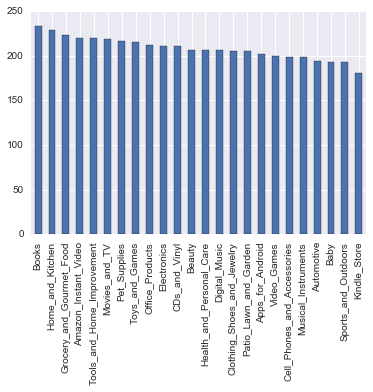

In [70]:
# histogram of categories
fig, ax = plt.subplots()
df['category'].value_counts().plot(ax=ax, kind='bar')
df['category'].value_counts().sum()

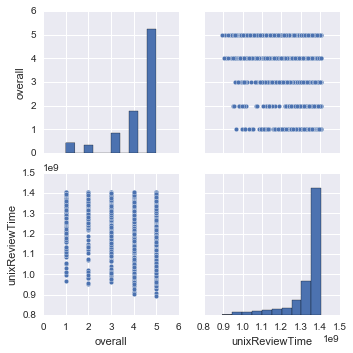

In [71]:
# visualize distribution of features and pairwise relationship using seaborn pairplot
sbn.pairplot(df)

In [72]:
df.corr()

,overall,unixReviewTime
overall,1.000000,0.031152
unixReviewTime,0.031152,1.000000


## Data Pre Processing

We will map the 24 categories to numerical values from 0 to 23.

In [73]:
df['category'] = df['category'].astype('category')

mapper = dict( enumerate(df.category.cat.categories) )
print(mapper)
df['category_encode'] = df['category'].cat.codes
print(df['category_encode'])

{0: 'Amazon_Instant_Video', 1: 'Apps_for_Android', 2: 'Automotive', 3: 'Baby', 4: 'Beauty', 5: 'Books', 6: 'CDs_and_Vinyl', 7: 'Cell_Phones_and_Accessories', 8: 'Clothing_Shoes_and_Jewelry', 9: 'Digital_Music', 10: 'Electronics', 11: 'Grocery_and_Gourmet_Food', 12: 'Health_and_Personal_Care', 13: 'Home_and_Kitchen', 14: 'Kindle_Store', 15: 'Movies_and_TV', 16: 'Musical_Instruments', 17: 'Office_Products', 18: 'Patio_Lawn_and_Garden', 19: 'Pet_Supplies', 20: 'Sports_and_Outdoors', 21: 'Tools_and_Home_Improvement', 22: 'Toys_and_Games', 23: 'Video_Games'}
0       20
1        5
2       11
3        7
4        0
5        3
6       21
7        9
8       19
9       15
10      23
11      14
12      20
13      20
14       7
15      19
16      19
17      22
18      13
19      14
20      13
21       8
22       1
23      12
24       6
25       4
26       4
27      16
28      14
29      15
        ..
4970    23
4971    20
4972     5
4973     3
4974     1
4975     4
4976     5
4977     7
4978    16


In [74]:
# adding summary to reviewText
df['reviewText'] = df['summary'] + ' ' + df['reviewText']

In [75]:
# convert text to lowercase
df.loc[:, 'reviewText'] = df['reviewText'].str.lower()

We then build our Tfidf matrix _features_

In [76]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

#create a stemmer
stemmer = SnowballStemmer("english")


#define our own tokenizing function that we will pass into the TFIDFVectorizer. We will also stem the words here.
def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems

#define the vectorizer
vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), min_df = 0.01)
#fit the vectorizers to the data.
features = vectorizer.fit_transform(df['reviewText'])
features

<5000x802 sparse matrix of type '<class 'numpy.float64'>'
	with 121632 stored elements in Compressed Sparse Row format>

In [77]:
# Try to build the tfidf matrix as in assignment 1
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import EnglishStemmer

stoplist = set('for a of the and to in'.split())

stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

stem_vectorizer = CountVectorizer(analyzer=stemmed_words)

# set up pipeline with the modified CountVectorizer
pipe_modified = Pipeline([('vectorize_stem', CountVectorizer(stop_words=stoplist,analyzer=stemmed_words)),\
                          ('compute_tfidf', TfidfTransformer())])

# fit modified pipeline, then carry out vectorization and transformation in one shot
pipe_modified.fit(df['reviewText'])
documents_tfidf = pipe_modified.transform(df['reviewText'])

In [78]:
documents_tfidf.shape

(5000, 19078)

## Step 1

In [79]:
from sklearn.model_selection import train_test_split

cat_coded = df['category_encode'].values.tolist()

# Split the data in 80% training set and 20% test set
X_train, X_test, y_train, y_test = train_test_split(documents_tfidf, cat_coded, test_size=0.2, random_state=SEED)

As a baseline model to assess the performance of our prediction we will use the following dummy classifier. Note that we use the stratified strategy.

In [80]:
# set up dummy classifier and fit it to training data
clf_dummy = dummy.DummyClassifier(strategy="uniform", random_state=SEED)
clf_dummy.fit(X_train, y_train)
clf_dummy.score(X_test, y_test)

0.050999999999999997

In [81]:
y_pred = clf_dummy.predict(X_test)
print("accuracy :", np.mean(y_pred == y_test))

accuracy : 0.051


false positive rates: [ 0.  1.]
true positive rates:  [ 0.  1.]
thresholds: [ 1.04166667  0.04166667]
area under roc curve:  0.5


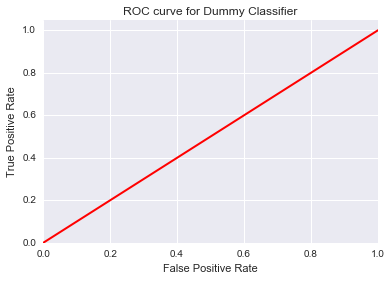

In [82]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# DUMMY classifier returned probabilities
clf_dummy_pred = clf_dummy.predict_proba(X_test)

# compute false positive rate, true positive rate and thresholds defining ROC curve
# (note: these values define the points at which the ROC curve has a kink)
fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_test, clf_dummy_pred[:,1], pos_label=1)
print('false positive rates:', fpr_dummy)
print('true positive rates: ', tpr_dummy)
print('thresholds:', thresholds_dummy)

# compute and show area under the ROC curve
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)
print ('area under roc curve: ', roc_auc_dummy)

# plot the ROC curve
plt.plot(fpr_dummy, tpr_dummy, color='red',lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC curve for Dummy Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [83]:
# define a pipeline with maxabs standardization preprocessing with Euclidean measure of distance
estimators = []
estimators.append(('MaxAbsScalar', preprocessing.MaxAbsScaler()))
estimators.append(('knn_cls', neighbors.KNeighborsClassifier()))
cls_knn_pipe = Pipeline(estimators)
cls_knn_pipe.set_params(knn_cls__algorithm='brute')
cls_knn_pipe.set_params(knn_cls__weights='distance')

# create a grid search over n_neighbors values
parameters = {
        'knn_reg__n_neighbors' : np.arange(1,100)
}
estimator_knncls = GridSearchCV(cls_knn_pipe, parameters, cv=5)
                  
# evaluate the grid search and print best regressor
estimator_knnreg.fit(X_train, y_train)
estimator_knnreg.best_estimator_

Pipeline(steps=[('MaxAbsScalar', MaxAbsScaler(copy=True)), ('knn_reg', KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=24, p=2,
          weights='uniform'))])

In [84]:
# fix the number of neighbors to the best value
cls_knn_pipe.set_params(knn_cls__n_neighbors=38)

# fit the model to the training set
cls_knn_pipe.fit(X_train, y_train)

# assess the performance on the test set using R^2 score
cls_knn_pipe.score(X_test, y_test)

0.106

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import Normalizer

# setup pipeline
estimators = []
estimators.append(('normalize', Normalizer()))
estimators.append(('svm_clf', svm.SVC()))
pipe = Pipeline(estimators)
pipe.set_params(svm_clf__kernel='linear')

# tuning requsted parameter
tuned_parameters = [{'svm_clf__C': np.logspace(-5,15,11,base=2.0)}]
clf = GridSearchCV(pipe, tuned_parameters, cv=5, scoring='accuracy')
clf.fit(X_train,y_train)
clf.best_params_

{'svm_clf__C': 2.0}

In [86]:
clf.cv_results_

{'mean_fit_time': array([ 17.68916602,  17.26037765,  14.51102138,  16.74139919,
         16.73741055,  16.73710585,  16.75811768,  16.73433475,
         16.75400391,  16.74625034,  16.92438874]),
 'mean_score_time': array([ 2.58243618,  2.52217765,  2.42430105,  2.40927219,  2.41481242,
         2.52036538,  2.41870079,  2.40264912,  2.4178627 ,  2.42385588,
         2.41891742]),
 'mean_test_score': array([ 0.0485 ,  0.2905 ,  0.59325,  0.63025,  0.6295 ,  0.62925,
         0.62925,  0.62925,  0.62925,  0.62925,  0.62925]),
 'mean_train_score': array([ 0.0485001 ,  0.35171669,  0.88393599,  0.99793696,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,  1.        ]),
 'param_svm_clf__C': masked_array(data = [0.03125 0.125 0.5 2.0 8.0 32.0 128.0 512.0 2048.0 8192.0 32768.0],
              mask = [False False False False False False False False False False False],
        fill_value = ?),
 'params': ({'svm_clf__C': 0.03125},
  {'svm_clf__C': 0.125},
 

In [87]:
# best C value using GridSearchCV
best_C_SVC = 0.5

In [88]:
# assessing best performing SVC on test set
from sklearn.metrics import accuracy_score

# setup pipeline
estimators = []
estimators.append(('normalize', Normalizer()))
estimators.append(('svm_clf', svm.SVC()))
pipe = Pipeline(estimators)
pipe.set_params(svm_clf__kernel='linear', svm_clf__C=best_C_SVC)

pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
accuracy_score(y_test, y_pred)

0.60999999999999999